<a href="https://colab.research.google.com/github/PatricRc/Stock_price_prediction/blob/main/modelo_prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance -q

In [11]:
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import pandas as pd
from keras.models import load_model

In [3]:
end = dt.datetime.now()
start = '2010-01-01'

tickers = ['TSLA']

In [4]:
df = yf.download(tickers,start,end)

[*********************100%***********************]  1 of 1 completed


In [5]:
df = df.reset_index().drop(['Date','Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,3.800,5.000,3.508,4.778,93831500
1,5.158,6.084,4.660,4.766,85935500
2,5.000,5.184,4.054,4.392,41094000
3,4.600,4.620,3.742,3.840,25699000
4,4.000,4.000,3.166,3.222,34334500


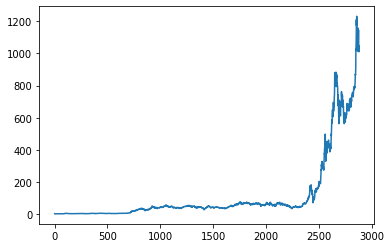

In [6]:
plt.plot(df.Close)

In [7]:
ma100 = df['Close'].rolling(100).mean()
ma200 = df['Close'].rolling(200).mean()

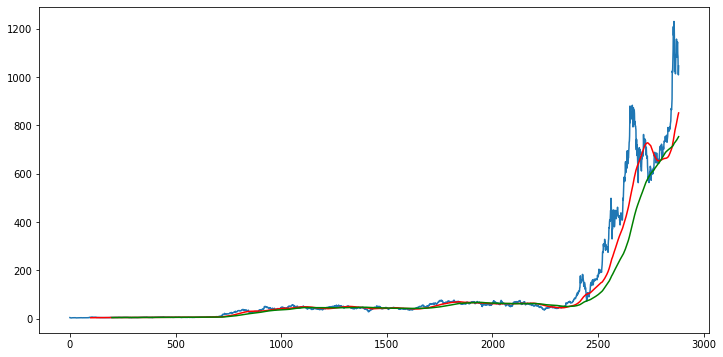

In [8]:
plt.figure(figsize= (12,6))
plt.plot(df['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [9]:
df.shape

(2882, 5)

In [12]:
# separando data de entrenamiento y de prueba

df_entrenado = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
df_prueba = pd.DataFrame(df['Close'][int(len(df)*0.70) : int(len(df))])

print(df_entrenado.shape)
print(df_prueba.shape)

(2017, 1)
(865, 1)


In [13]:
df_prueba.head()

,Close
2017,62.172001
2018,61.832001
2019,61.779999
2020,63.702000
2021,64.494003


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [15]:
df_entrenado_array = scaler.fit_transform(df_entrenado)

In [16]:
df_entrenado_array.shape

(2017, 1)

In [17]:
x_entrenado = []
y_entrenado = []

for i in range(100, df_entrenado_array.shape[0]):
    x_entrenado.append(df_entrenado_array[i-100: i])
    y_entrenado.append(df_entrenado_array[i, 0])

x_entrenado, y_entrenado = np.array(x_entrenado), np.array(y_entrenado)

In [18]:
# ML Model usando keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [19]:
model = Sequential()
model.add(LSTM(units = 50, activation= 'relu', return_sequences= True,
               input_shape= (x_entrenado.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation= 'relu', return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation= 'relu', return_sequences= True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation= 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units= 1))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [21]:
model.compile(optimizer='adam', loss= 'mean_squared_error')
model.fit(x_entrenado, y_entrenado, epochs=10)

Epoch 1/10
60/60 [==============================] - 22s 278ms/step - loss: 0.0485
Epoch 2/10
60/60 [==============================] - 17s 276ms/step - loss: 0.0096
Epoch 3/10
60/60 [==============================] - 17s 275ms/step - loss: 0.0115
Epoch 4/10
60/60 [==============================] - 17s 279ms/step - loss: 0.0090
Epoch 5/10
60/60 [==============================] - 17s 275ms/step - loss: 0.0079
Epoch 6/10
60/60 [==============================] - 17s 281ms/step - loss: 0.0073
Epoch 7/10
60/60 [==============================] - 17s 276ms/step - loss: 0.0070
Epoch 8/10
60/60 [==============================] - 17s 277ms/step - loss: 0.0081
Epoch 9/10
60/60 [==============================] - 17s 277ms/step - loss: 0.0067
Epoch 10/10
60/60 [==============================] - 17s 277ms/step - loss: 0.0064


In [22]:
model.save('modelo_keras.h5')

In [23]:
pasados_100d = df_entrenado.tail(100)

In [24]:
df_final = pasados_100d.append(df_prueba, ignore_index=True)

In [25]:
df_final

,Close
0,63.046001
1,62.084000
2,63.146000
3,64.732002
4,64.461998
...,...
960,1095.000000
961,1084.599976
962,1014.969971
963,1009.010010


In [26]:
input_df = scaler.fit_transform(df_final)

In [27]:
input_df.shape

(965, 1)

In [28]:
x_prueba = []
y_prueba = []

for i in range(100,input_df.shape[0]):
    x_prueba.append(input_df[i-100: i])
    y_prueba.append(input_df[i,0])

In [29]:
x_prueba, y_prueba = np.array(x_prueba), np.array(y_prueba)

In [30]:
y_predicted = model.predict(x_prueba)

In [31]:
y_predicted.shape

(865, 1)

In [32]:
scaler.scale_

array([0.00083744])

In [33]:
scale_factor = 1/0.00083744
y_predicted = y_predicted * scale_factor
y_prueba = y_prueba * scale_factor

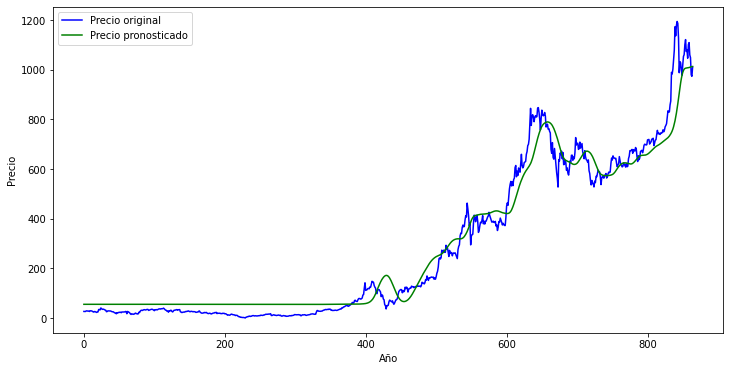

In [34]:
plt.figure(figsize=(12,6))
plt.plot(y_prueba, 'b', label='Precio original')
plt.plot(y_predicted, 'g', label='Precio pronosticado')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.legend()
plt.show()